Description:
This Jupyter Notebook performs the analysis of 19F nuclear magnetic resonance spectroscopy (NMR) data. The analysis involves two sets of data, as detailed in the accompanying readme.txt file. The data sets consist of Sodium fluoride (NaF) standards, where the integral is calculated to determine the fluoride concentration of unknowns.

Data Source:
Before running this notebook, download the required data from Zenodo. The data are provided in .ft2 format, and the filenames follow specific conventions. For NaF standards, filenames indicate both the concentration and replica index (e.g., '50uM_0.ft2' indicates 50uM NaF, first replicate). When determining fluoride concentration, filenames indicate the index and the tested condition, such as the type of tube or the presence of an additional compound (e.g., '1_wilmad' indicates buffer incubated in a wilmad tube).

Output:
The results of the analysis are saved as .svg files in the Results/ directory.


In [1]:
# Import useful stuff
%matplotlib inline
import os, sys
import nmrglue as ng
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
from fit_raw import * # the included fit_raw.py file contains some useful functions
from scipy.stats import linregress
import matplotlib.ticker as ticker  # Import the ticker module
import re #Search prefixes in the file path 

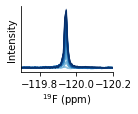

In [2]:
# Plot various 1D 19F NMR standard curves together
# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process the data
dic, data = fit_1D_19F.read_data('Standards_19F_1D_spectra')

# Define a regular expression pattern to match the numeric part of the concentration prefix
pattern = re.compile(r'(\d+)uM_\d+')

# Create a dictionary to group data by concentration
group_dict = {}

# Iterate over the file paths in 'data'
for key in data.keys():
    # Use re.search to find the match
    match = pattern.search(key)
    
    # Extract the numeric part of the concentration prefix
    concentration = int(match.group(1)) if match else None
    
    # Add the file path to the 'group_dict' dictionary based on the concentration number
    if concentration is not None:
        if concentration not in group_dict:
            group_dict[concentration] = []
        group_dict[concentration].append(key)

# Sort the dictionary keys by concentration
sorted_keys = sorted(group_dict.keys(), key=lambda x: int(x))

# Set spectra colours
colors = plt.cm.Blues(np.linspace(0.4, 1.0, len(sorted_keys)))

# Create the plot for average spectra with error bars
fig, ax = plt.subplots(figsize=(1.65, 1.21), facecolor = 'none')

# Initialize dictionaries to store average integrals and their standard errors
average_integrals = {}
integral_errors = {}


# Find the spectrum corresponding to 100 uM
spectrum_100uM = None
for concentration, keys in group_dict.items():
    if concentration == 100:  # Adjust this to match your concentration format
        spectrum_100uM = data[keys[0]]  # Assuming there's only one spectrum for 100 uM
        break

if spectrum_100uM is None:
    raise ValueError("Spectrum for 100 uM not found in the data.")


# Loop over grouped data, calculate average integrals and standard errors
for i, prefix in enumerate(sorted_keys):
    keys = group_dict[prefix]
    spectra = []
    integrals = []  # List to store individual integrals for standard error calculation
    for key in keys:
        spectrum = data[key]
        spectra.append(spectrum)
        integrals.append(np.trapz(spectrum))
    avg_spectrum = np.mean(spectra, axis=0)
    ste_spectrum = np.std(spectra, axis=0) / np.sqrt(len(spectra))
    
    average_integrals[prefix] = np.mean(integrals)
    integral_errors[prefix] = np.std(integrals) / np.sqrt(len(integrals))

    # Normalize the spectrum by dividing by the intensity at 100 uM (I/I100)
    avg_spectrum_normalized = avg_spectrum / np.max(spectrum_100uM)
    ste_spectrum_normalized = ste_spectrum / np.max(spectrum_100uM)

    # Get the x-axis values (ppm_real)
    udic = ng.pipe.guess_udic(dic[keys[0]], data[keys[0]])
    ppm_real = np.linspace(-120+-(udic[0]['sw']/udic[0]['obs'])/2, -120+(udic[0]['sw']/udic[0]['obs'])/2, num=data[keys[0]].shape[0])

    # Plot the normalized average spectrum with standard error using the color map
    ax.plot(ppm_real, avg_spectrum_normalized, label=prefix, color=colors[i])  # Reversed x-axis
    ax.fill_between(ppm_real, avg_spectrum_normalized-ste_spectrum_normalized, avg_spectrum_normalized+ste_spectrum_normalized, alpha=0.7, color=colors[i])  # Reversed x-axis

#Format and label the plot
#setting plot font size and style

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
#setting plot titles 
ax.set_xlabel(r'$\mathrm{^{19}F}$ (ppm)', labelpad=2)
ax.set_ylabel('Intensity')
ax.set_yticks([]) #no axis values 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-119.7, -120.2)
# Set the background color of the axes to transparent
ax.set_facecolor('none')

# Save figure 
fig.savefig('Results/standards_spectra.svg', transparent=True, bbox_inches='tight', dpi=1200)


# Show plot
plt.show()

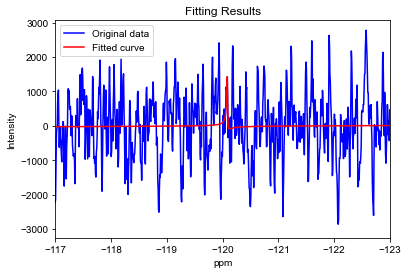

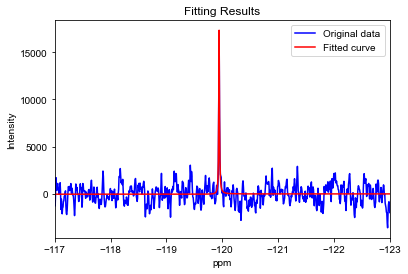

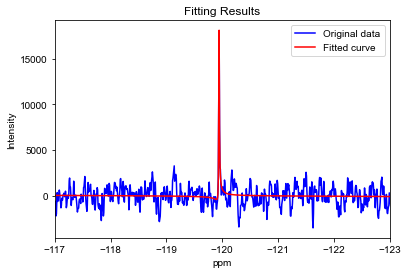

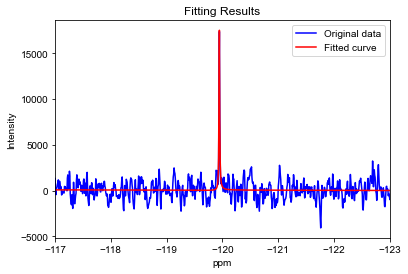

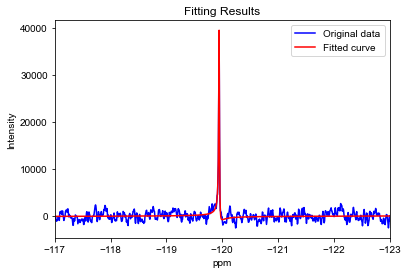

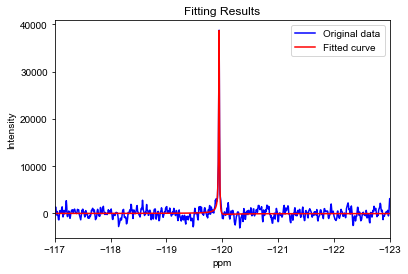

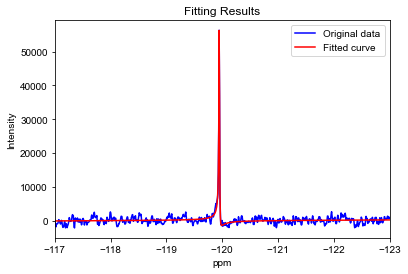

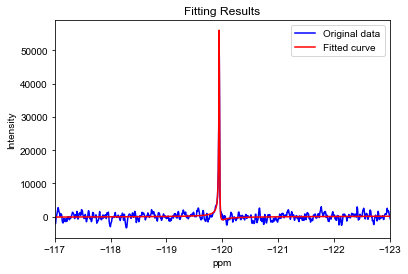

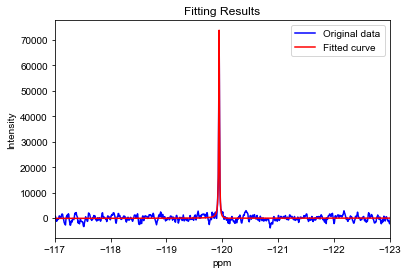

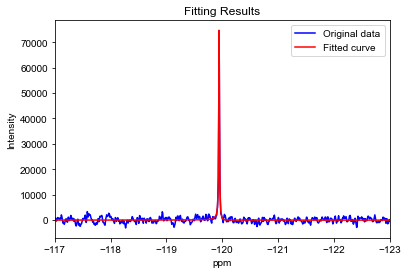

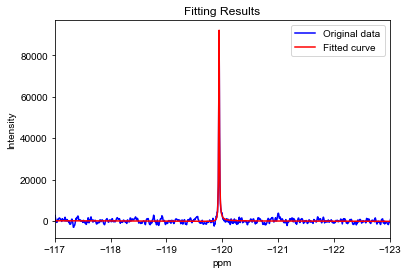

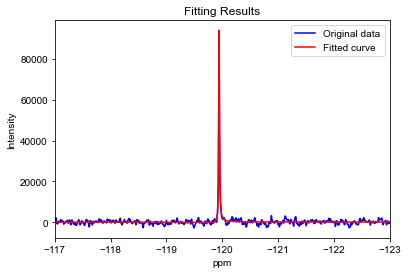

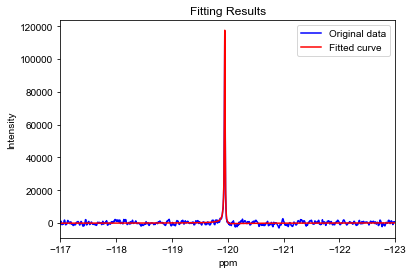

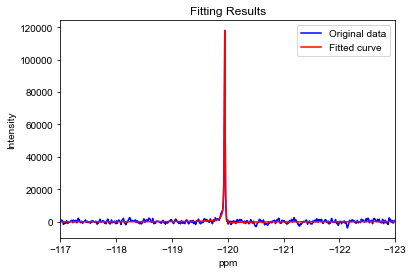

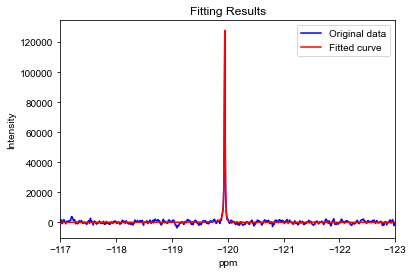

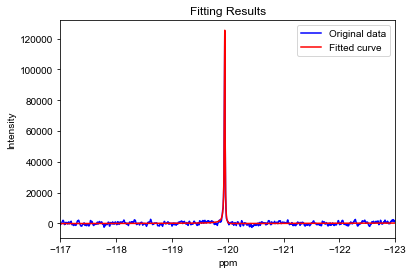

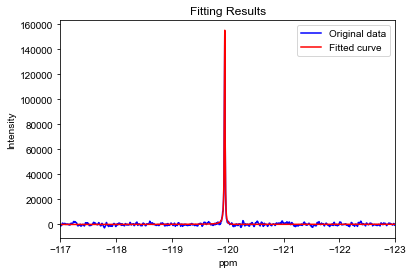

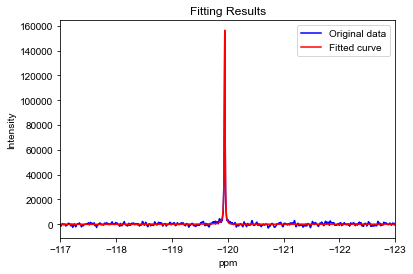

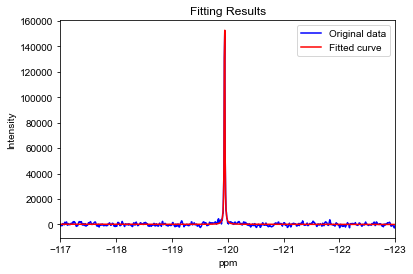

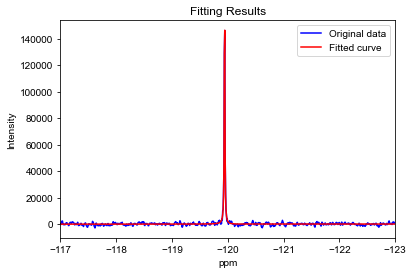

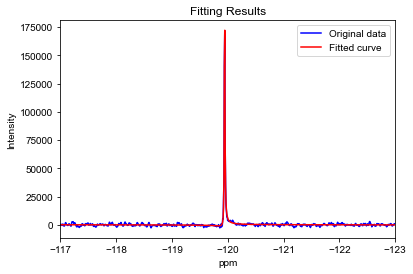

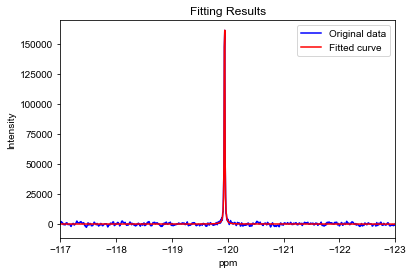

523990.75903634424


In [3]:
#Fit the standards' spectra using a Lorentzian function and use that to calculate the integral at a specified range
# Define the ppm range you want to integrate within
ppm_range_start = -120  # Replace with your desired start ppm
ppm_range_end = -119.9  # Replace with your desired end ppm

# Create an instance of the fit_raw class
fit_obj = fit_raw()

# Create dictionaries to store vals and integrals by concentration
concs_f0s_av = {}
concs_f0s_se = {}
concs_integrals = {}  # Dictionary to store integrals

# Create a dictionary to map concentration labels to floats
concentration_mapping = {key: float(key) for key in sorted_keys}

# Lists to store the SEM and normalized average integral values
sem_values = []
normalized_average_integral_values = []

# Loop over grouped data, calculate average, standard error, and integrals
for key in sorted_keys:
    # Calculate average and standard error for chemical shifts (f0)
    f0_vals = []
    f0_errs = []

    # Initialize a list to store integrals for this concentration
    integrals = []

    for spectrum_key in group_dict[key]:
        popt, perr, fit_curve = fit_obj.fit_1D(dic=dic[spectrum_key], data=data[spectrum_key])
        f0_vals.append(popt[0])
        f0_errs.append(perr[0])

        # Find the indices of ppm values within the specified ppm range
        low_value_index = np.argmin(np.abs(ppm_real - ppm_range_start))
        high_value_index = np.argmin(np.abs(ppm_real - ppm_range_end))

        # Calculate the integral within the specified ppm range
        integral = np.trapz(fit_curve[low_value_index:high_value_index + 1])
        integrals.append(integral)

    # Calculate the mean and standard error of chemical shifts (f0)
    concs_f0s_av[key] = np.mean(f0_vals, axis=0)
    concs_f0s_se[key] = np.sqrt(np.sum(np.asarray(f0_errs) ** 2) / 3)

    # Store the integrals for this concentration in the dictionary
    concs_integrals[key] = integrals

# Calculate the maximum integral value across all concentrations
max_integral = max(max(integrals) for integrals in concs_integrals.values())

# Normalize the average integral values based on the maximum integral
normalized_average_integral_values = [np.mean(integrals) / max_integral for integrals in concs_integrals.values()]

# Calculate the standard error of the mean (SEM) for the integral values
sem_values = [np.std(integrals) / np.sqrt(len(integrals)) for integrals in concs_integrals.values()]

# Normalize the SEM values based on the maximum integral
normalized_sem_values = [sem_value / max_integral for sem_value in sem_values]

# Extract and sort the concentrations
concentration_labels = sorted_keys
concentrations = [float(label) for label in concentration_labels]
sorted_indices = np.argsort(concentrations)
sorted_concentrations = [concentration_labels[i] for i in sorted_indices]
sorted_average_integral_values = [normalized_average_integral_values[i] for i in sorted_indices]
sorted_sem_values = [normalized_sem_values[i] for i in sorted_indices]

# Use the mapped float values for the x-axis
x_values = [concentration_mapping[key] for key in sorted_concentrations]

#saving 100uM average integral value for further analysis
average_integral_100uM = np.mean(concs_integrals[100])
print(average_integral_100uM)


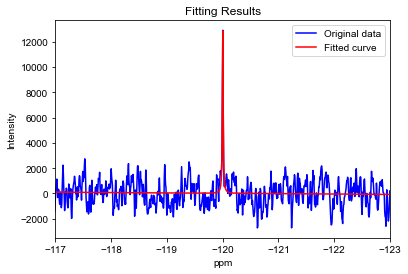

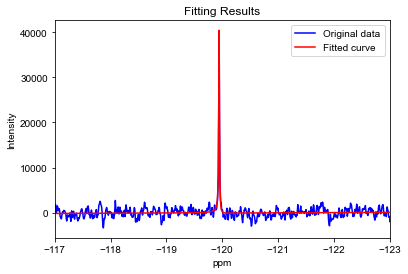

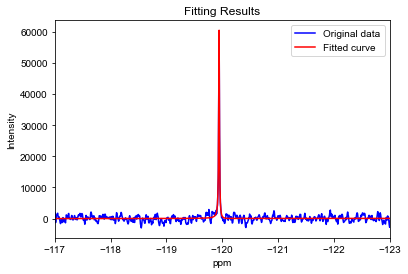

In [4]:
# Use spectra from different NMR glass tube brands and fit them using a Lorentzian function, 
# then calculate the integral between a specified range
# Read and process the data from the current dataset
dic, data = fit_1D_19F.read_data('Brands_19F_1D_spectra')
# Create a dictionary to add spectra data 
group_dict_brand = {}
for key in data.keys():
    prefix = key.split("_")[-1]
    join = prefix
    if join not in group_dict_brand:
        group_dict_brand[join] = []
    group_dict_brand[join].append(key)
    
# Sort the dictionary keys by index number 
sorted_brand_keys = list(group_dict_brand.keys())

# Define the ppm range you want to integrate within
ppm_range_start = -120  # Replace with your desired start ppm
ppm_range_end = -119.9  # Replace with your desired end ppm

# Create an instance of the fit_raw class
fit_obj = fit_raw()


# Initialize a list to store normalized integral values
normalized_integral_values_brand = []

# Loop over grouped data and calculate integrals for each
for key in sorted_brand_keys:
    # Initialize a list to store integrals for each
    integrals_brand = []

    for spectrum_key in group_dict_brand[key]:
        popt, _, fit_curve = fit_obj.fit_1D(dic=dic[spectrum_key], data=data[spectrum_key])

        # Find the indices of ppm values within the specified ppm range
        low_value_index = np.argmin(np.abs(ppm_real - ppm_range_start))
        high_value_index = np.argmin(np.abs(ppm_real - ppm_range_end))

        # Calculate the integral within the specified ppm range
        integral = np.trapz(fit_curve[low_value_index:high_value_index + 1])
        integrals_brand.append(integral)

    # Calculate the normalized average integral values
    normalized_integrals = [integral / average_integral_100uM for integral in integrals_brand]
    normalized_average_integral = np.mean(normalized_integrals)
    normalized_integral_values_brand.append(normalized_average_integral)



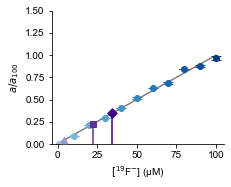

In [5]:
# Use the integral values to plot a standard curve with the integral values of the brands annotated
# Create a figure and an axis object
fig, ax = plt.subplots()

# Create a scatter plot with points and error bars
for i, concentration_label in enumerate(sorted_concentrations):
    x_data = x_values[i]
    y_data = sorted_average_integral_values[i]
    error_data = sorted_sem_values[i]

    color = plt.cm.Blues(0.4 + 0.6 * i / len(sorted_concentrations))
    plt.scatter(x_data, y_data, label=concentration_label, color=color)

    plt.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor=color, capsize=5, markersize=5)

# Perform linear regression using linregress
slope, intercept, r_value, p_value, std_err = linregress(x_values, sorted_average_integral_values)
# Calculate the y-values for the regression line
regression_line = [slope * x + intercept for x in x_values]

# Plot the regression line
plt.plot(x_values, regression_line, color='gray', label=f'Best Fit (R-squared={r_value**2:.2f})', zorder=-1)

# Create vertical lines ending at the line of best fit with different shades of purple
for i, normalized_integral in enumerate(normalized_integral_values_brand):
    x_intersection = (normalized_integral - intercept) / slope
    line_color = plt.cm.Purples(0.5 + 1.0 * i / len(normalized_integral_values_brand))
    plt.plot([x_intersection, x_intersection], [0, normalized_integral], color=line_color, linestyle='-', label=f'Brand {i + 1} (x-value)')
    
# Define a list of marker styles (e.g., triangle, square, circle, etc.)
marker_styles = ['^', 's', 'D']

# Create vertical markers with different shapes and shades of purple
for i, normalized_integral in enumerate(normalized_integral_values_brand):
    x_intersection = (normalized_integral - intercept) / slope
    line_color = plt.cm.Purples(0.5 + 1.0 * i / len(normalized_integral_values_brand))
    marker_style = marker_styles[i % len(marker_styles)]  # Cycle through marker styles
    plt.scatter(x_intersection, normalized_integral, color=line_color, marker=marker_style, s=45, label=f'Brand {i + 1} (x-value)', zorder=10)


# Set axis labels and title
fig.set_size_inches(3.307, 2.7)  # Set the figure size
fig.patch.set_facecolor('none')  # Make the background transparent
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
ax.set_ylim(0, 1.5)
ax.set_facecolor('none')
ax.set_xlabel('$[^{19}$F$^{-}$] (\u03BCM)')
ax.set_ylabel(r'$a/a_{100}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save figure 
fig.savefig('Results/standard_curve.svg', transparent=True, bbox_inches='tight', dpi=1200)

# Display the legend and show the plot
# plt.legend()
plt.show()


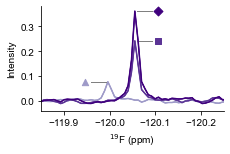

In [6]:
# Plot and annotate spectra from different types of NMR glass tubes, normalised using the 100 uM spectra collected above
# Read and process the data from the current dataset
dic, data = fit_1D_19F.read_data('Brands_19F_1D_spectra')

# Read and process the data from the dataset containing 100 uM spectrum
dic_100uM, data_100uM = fit_1D_19F.read_data('Normalise_19F_1D_spectra') 

# Create a dictionary to add spectra
group_dict = {}
for key in data.keys():
    join = key.split("_")[-1]
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Sort the dictionary keys by index number 
sorted_keys = list(group_dict.keys())

# Calculate the average spectrum for 100 uM
spectrum_100uM = np.mean(list(data_100uM.values()), axis=0)

# Initialize lists to store average integrals and standard errors
avg_spectra = []
ste_spectra = []

# Define colors using plt.cm.Purples (must match the purple color distribution above)
colors = [plt.cm.Purples(0.5 + 1.0 * i / len(sorted_keys)) for i in range(len(sorted_keys))]

# Create a single plot for all the data
fig, ax = plt.subplots(figsize=(3.307, 2.25), facecolor='none')

# Set font properties for all text elements to Arial and 10pt
font = {'family': 'Arial', 'size': 10}
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']

# Define a list of symbols
symbols = ['^', 's', 'D', 'v', '<', '>', 'p', '*', '+', 'x']

# Loop over grouped data, calculate average integrals and standard errors
for i, prefix in enumerate(sorted_keys):
    keys = group_dict[prefix]
    spectra = []
    for key in keys:
        spectra.append(data[key])
    avg_spectrum = np.mean(spectra, axis=0)
    ste_spectrum = np.std(spectra, axis=0) / np.sqrt(len(spectra))
    
    # Find the index of the maximum y-value
    max_y_index = np.argmax(avg_spectrum)

    # Get the corresponding x-axis value
    max_x_value = ppm_real[max_y_index]

    # Get the x-axis values (ppm_real) in reverse order
    udic = ng.pipe.guess_udic(dic[keys[0]], data[keys[0]])
    ppm_real = np.linspace(-120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                           -120 + (udic[0]['sw'] / udic[0]['obs']) / 2, num=data[keys[0]].shape[0])[::-1]

    # Assign colors using the 'colors' definition
    color = colors[i]

    # Normalize the average spectrum by dividing by the intensity at 100 uM (I/I100)
    avg_spectrum_normalized = avg_spectrum / np.max(spectrum_100uM)
        
    # Find the index of the maximum y-value
    max_y_index = np.argmax(avg_spectrum_normalized)

    # Get the corresponding x-axis value
    max_x_value = ppm_real[max_y_index]


    # Plot the normalized average spectra with standard errors using the determined color
    ax.plot(ppm_real, avg_spectrum_normalized, label=prefix, color=color)
    ax.fill_between(ppm_real, avg_spectrum_normalized - ste_spectrum, avg_spectrum_normalized + ste_spectrum, alpha=0.7, color=color)

    if 'w' in prefix.lower():  # Corrected this line
        # Add symbols above each spectrum
        max_y_value = max(avg_spectrum_normalized)
        symbol_index = i % len(symbols)  # Use modulo to cycle through the list of symbols
        symbol = symbols[symbol_index]
        ax.scatter(max_x_value + 0.05, max_y_value, marker=symbol, color=color, s=40, zorder=10)
        ax.plot([max_x_value + 0.005 , max_x_value + 0.037], [max_y_value, max_y_value], color='gray', linestyle='-', linewidth=1.0)

    else:
        max_y_value = max(avg_spectrum_normalized)
        symbol_index = i % len(symbols)  # Use modulo to cycle through the list of symbols
        symbol = symbols[symbol_index]
        ax.scatter(max_x_value - 0.05, max_y_value, marker=symbol, color=color, s=40, zorder=10)
        ax.plot([max_x_value - 0.005, max_x_value - 0.037], [max_y_value, max_y_value], color='gray', linestyle='-', linewidth=1.0)

# Format and label the plot
ax.set_xlabel("$^{19}$F (ppm)")
# Hide the y-axis tick labels and set the y-axis title
#plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.ylabel('Intensity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-119.85, -120.25)
ax.set_facecolor('none')

# Show the plot
plt.tight_layout()

# Save figure 
fig.savefig('Results/brands_spectra.svg', transparent=True, bbox_inches='tight', dpi=1200)

# View figure 
plt.show()



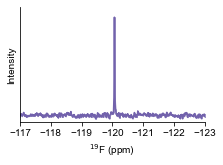

<Figure size 432x288 with 0 Axes>

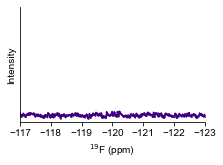

<Figure size 432x288 with 0 Axes>

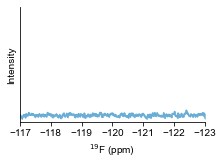

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot nulls spectra separately with colour based on tube type
# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process the data
dic, data = fit_1D_19F.read_data('Nulls_19F_1D_spectra')

# Create a dictionary to group data
group_dict = {}
for key in data.keys():
    join = key.split("_")[-1]
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Sort the dictionary keys by index number
sorted_keys = list(group_dict.keys())

# Initialize lists to store average integrals and standard errors
avg_spectra = []
ste_spectra = []

# Define a list of colors for "glass" prefixes
glass_prefixes = [prefix for prefix in sorted_keys if "glass" in prefix.lower()]
glass_colors = plt.cm.Purples(np.linspace(0.7, 1.0, len(glass_prefixes)))

# Loop over grouped data and create separate plots
for i, prefix in enumerate(sorted_keys):
    keys = group_dict[prefix]
    spectra = []

    # Create a new figure for each group
    fig, ax = plt.subplots(figsize=(3.307, 2.12), facecolor='none')

    for key in keys:
        spectra.append(data[key])
    
    avg_spectrum = np.mean(spectra, axis=0)
    ste_spectrum = np.std(spectra, axis=0) / np.sqrt(len(spectra))

    # Get the x-axis values (ppm_real) in reverse order
    udic = ng.pipe.guess_udic(dic[keys[0]], data[keys[0]])
    ppm_real = np.linspace(-120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                           -120 + (udic[0]['sw'] / udic[0]['obs']) / 2, num=data[keys[0]].shape[0])[::-1]

    # Determine the color based on the presence of "glass" in the prefix
    if prefix in glass_prefixes:
        color = glass_colors[glass_prefixes.index(prefix)]
    else:
        color = plt.cm.Blues(0.5)  # Adjust the value as needed for non-"glass" prefixes

    # Plot the average spectra with standard errors using the determined color
    ax.plot(ppm_real, avg_spectrum, label=prefix, color=color)
    ax.fill_between(ppm_real, avg_spectrum - ste_spectrum, avg_spectrum + ste_spectrum, alpha=0.7, color=color)

    # Format and label the subplot
    ax.set_xlabel("$^{19}$F (ppm)")
    ax.set_ylabel('Intensity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-5000, 80000)
    ax.set_xlim(-117, -123)
    ax.set_facecolor('none')

    # Remove y-axis tick marks and labels
    ax.set_yticks([])

    # Save each subplot as an individual file
    filename = f'Results/nulls_{prefix}.svg'
    # View figure 
    plt.show()
    plt.tight_layout()
    plt.savefig(filename, transparent=True, dpi=1200)
    plt.show()
    plt.close()  # Close the current figure to avoid overlapping

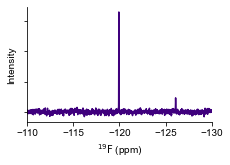

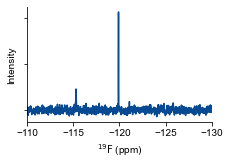

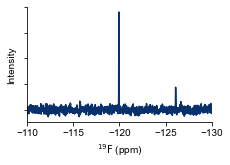

In [8]:
# Plot and annotate spectra of fluorinated compounds based on glass type 
# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process the data
dic, data = fit_1D_19F.read_data('Compounds_19F_1D_spectra')

# Create a dictionary to group data
group_dict = {}
for key in data.keys():
    # Extract glass tube and compound information
    join = key.split('_')[-1]
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Separate spectra based on the presence of "glass" or "quartz" using a case-insensitive check
glass_spectra = [data[key] for keys in group_dict.values() for key in keys if "glass" in key.lower()]
quartz_spectra = [data[key] for keys in group_dict.values() for key in keys if "quartz" in key.lower()]

# Plot "glass" spectra separately
for i, spectrum in enumerate(glass_spectra):
    udic = ng.pipe.guess_udic(dic[list(data.keys())[i]], spectrum)
    ppm_real = np.linspace(-120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                           -120 + (udic[0]['sw'] / udic[0]['obs']) / 2, num=spectrum.shape[0])
    fig, ax = plt.subplots(figsize=(3.307, 2.12))
    color = plt.cm.Purples(1.0)
    ax.plot(ppm_real[:], spectrum, color=color)
    ax.set_xlim(-110, -130)
    ax.set_xlabel(r'$\mathrm{^{19}F}$ (ppm)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_ylabel('Intensity')
    plt.savefig(f"Results/glass_spectrum_{i + 1}.svg", transparent=True, dpi=1200)
    plt.show()

# Plot each "quartz" spectrum separately
for i, spectrum in enumerate(quartz_spectra):
    udic = ng.pipe.guess_udic(dic[list(data.keys())[i]], spectrum)
    ppm_real = np.linspace(-120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                           -120 + (udic[0]['sw'] / udic[0]['obs']) / 2, num=spectrum.shape[0])
    

    fig, ax = plt.subplots(figsize=(3.307, 2.12))
    color = plt.cm.Blues(0.9 + 0.3 * i / len(quartz_spectra))
    ax.plot(ppm_real[:], spectrum, color=color)
    ax.set_xlim(-110, -130)
    ax.set_xlabel(r'$\mathrm{^{19}F}$ (ppm)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Remove y-axis labels 
    ax.set_yticklabels([])
    ax.set_ylabel('Intensity')
    # Save files
    plt.savefig(f'Results/quartz_spectrum_{i + 1}.svg', transparent=True, dpi=1200)
    plt.show()


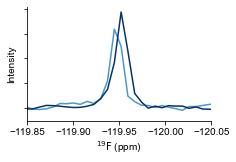

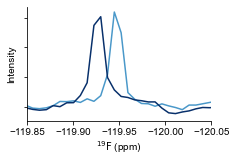

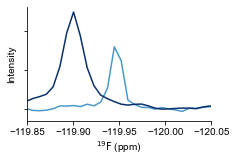

In [9]:
# Plot spectra of fluoride peak in the presence of various proteins
# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()
#Create list of directories for analysis
directories = ['d2d3_19F_1D_spectra','BSA_19F_1D_spectra','DNase_19F_1D_spectra']

#Read and process each directory separately 
for directory in directories:
    # Read and process the data
    dic, data = fit_1D_19F.read_data(directory)
    # Create a dictionary to group data
    group_dict = {}
    for key in data.keys():
        join = '.'.join(key.split("_")[-3:-1])  # Join concentration values
        if join not in group_dict:
            group_dict[join] = []
        group_dict[join].append(key)

    # Find the spectrum corresponding to the maximum concentration
    max_concentration = max(group_dict.keys(), key=lambda x: float(x))
    reference_spectrum = data[group_dict[max_concentration][0]]

    # Plot all spectra together in the same plot
    # Create a figure for all spectra
    fig_all, ax_all = plt.subplots(figsize=(3.3, 2.1), facecolor='none')

    # Loop over grouped data, accumulate all spectra for each concentration
    for i, prefix in enumerate(sorted(group_dict.keys(), key=lambda x: float(x))):
        keys = group_dict[prefix]
        spectra = []

        # Set spectra colours
        colors = plt.cm.Blues(np.linspace(0.6, 1.0, len(group_dict.keys())))
        # Loop over individual spectra for the current concentration
        for j, key in enumerate(keys):
            spectrum = data[key]
            spectra.append(spectrum)

            # Get the x-axis values (ppm_real)
            udic = ng.pipe.guess_udic(dic[key], spectrum)
            ppm_real = np.linspace(
                -120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                -120 + (udic[0]['sw'] / udic[0]['obs']) / 2,
                num=spectrum.shape[0]
            )

            # Plot each spectrum in the same plot with different colors
            color_index = j % len(colors)  # Use modulo to cycle through colors
            ax_all.plot(ppm_real, spectrum, label=f"{prefix}_{j+1}", color=colors[i % len(colors)])
        
    # Set font properties for all text elements to Arial and 10pt
    font = {'family': 'Arial', 'size': 10}
    plt.rcParams['font.family'] = font['family']
    plt.rcParams['font.size'] = font['size']
    # Set labels and other plot properties
    ax_all.set_xlabel(r'$\mathrm{^{19}F}$ (ppm)', labelpad=2)
    ax_all.set_ylabel('Intensity')
    # Remove y-axis labels 
    ax_all.set_yticklabels([])
    ax_all.set_xlim(-119.85, -120.05)
    ax_all.set_facecolor('none')
    #ax_all.legend()
    ax_all.spines['top'].set_visible(False)
    ax_all.spines['right'].set_visible(False)

    # Show the plot
    plt.show()
    #Generate filename for each dataset 
    filename = 'Results/spectra_all_' + directory.split('_')[0] + '.svg'
    # Save figure for all spectra
    fig_all.savefig(filename, transparent=True, bbox_inches='tight', dpi=1200)

    # Close the figure to avoid multiple plots in the same figure
    plt.close(fig_all)


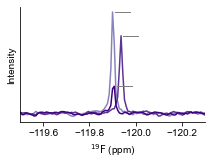

In [10]:
# Plot spectra of different buffers 
# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process the data
dic, data = fit_1D_19F.read_data('pH_19F_1D_spectra')

# Create a dictionary to group data by concentration
group_dict = {}
for key in data.keys():
    join = '.'.join(key.split('_')[-2:])
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Sort the dictionary keys by concentration
sorted_keys = sorted(group_dict.keys(), key=lambda x: float(x))

# Create a single plot for all spectra with different shades of purple
fig, ax = plt.subplots(figsize=(3.307, 2.12))

# Loop over grouped data and plot on the same subplot
for i, prefix in enumerate(sorted_keys):
    keys = group_dict[prefix]

    # Loop over individual spectra for the current group
    for key in keys:
        spectrum = data[key]

        # Get the x-axis values (ppm_real)
        udic = ng.pipe.guess_udic(dic[key], spectrum)
        ppm_real = np.linspace(-120 + -(udic[0]['sw'] / udic[0]['obs']) / 2,
                               -120 + (udic[0]['sw'] / udic[0]['obs']) / 2, num=spectrum.shape[0])

        # Plot the spectrum on the same subplot with different shades of purple
        color = plt.cm.Purples(0.6 + i / len(sorted_keys) * 0.7)
        ax.plot(ppm_real[:], spectrum, label=f'{prefix} - {key}', color=color)

    # Get the maximum y-value and corresponding index for the last spectrum in the group
    max_y_value = max(data[keys[-1]])
    max_y_index = np.argmax(data[keys[-1]])

    # Get the corresponding x-axis value
    max_x_value = ppm_real[max_y_index]

    # Plot the gray line (for labels)
    ax.plot([max_x_value - 0.01, max_x_value - 0.075], [max_y_value, max_y_value], color='gray', linestyle='-', linewidth=1.0)

# Set font properties for all text elements to Arial and 10pt
font = {'family': 'Arial', 'size': 10}
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']

# Format and label the subplot
ax.set_xlabel(r'$\mathrm{^{19}F}$ (ppm)')
ax.set_ylabel('Intensity')
ax.set_xlim(-119.5, -120.3)

# Remove y-axis tick marks and labels
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
#plt.savefig(f'Results/pH_all.svg', transparent=True, dpi=1200)

# Show plot
plt.show()
